In [1]:
import tensorflow as tf

import os
import pathlib
import time

import datetime

from matplotlib import pyplot as plt
from IPython import display

2024-05-11 14:33:07.282953: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 14:33:07.283044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 14:33:07.422403: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
import torchvision.transforms.functional as TF

class ResizeMaintainAspectRatio:
    def __init__(self, target_size):
        """
        target_size (int): The target size for the smallest dimension of the image.
        """
        self.target_size = target_size

    def __call__(self, image):
        # Compute the scaling factor to maintain aspect ratio.
        width, height = image.size
        min_dim = min(width, height)
        scaling_factor = self.target_size / min_dim
        
        new_width = max(256,int(width * scaling_factor))
        new_height = max(256,int(height * scaling_factor))

        # Resize the image with the computed dimensions
        image = TF.resize(image, (new_height, new_width))
        return image

class SplitAndCropTransform:
    def __init__(self, output_size, resize_transform=None):
        """
        output_size (tuple): Desired output size of the crop, e.g., (256, 256).
        resize_transform (callable): Transformation to resize the image.
        """
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            self.output_size = output_size
        self.resize_transform = resize_transform

    def __call__(self, image):
        # Split the image in half
        width, height = image.size
        input_image = image.crop((0, 0, width // 2, height))
        label_image = image.crop((width // 2, 0, width, height))
    

        # Resize each image if a resize transformation is specified
        if self.resize_transform:
            input_image = self.resize_transform(input_image)
            label_image = self.resize_transform(label_image)
            
        # Determine a random location to crop
        i, j, h, w = transforms.RandomCrop.get_params(
            input_image, output_size=self.output_size)

        input_image = TF.crop(input_image, i, j, h, w)
        label_image = TF.crop(label_image, i, j, h, w)

        # Optionally, you might want to apply cropping or other transformations here.
        return input_image, label_image

# Example of using the transformations
resize_transform = ResizeMaintainAspectRatio(256)
split_transform = SplitAndCropTransform((256, 256), resize_transform=resize_transform)




In [3]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import numpy as np
import matplotlib.pyplot as plt
import torch


class ImageDataset(Dataset):
    def __init__(self, directory, transform=None):
        """
        Args:
            directory (string): Path to the directory with images.
            transform (callable, optional): Optional additional transforms to be applied
                after splitting and cropping.
        """
        self.directory = directory
        self.transform = transform
        self.image_files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
        resize_transform = ResizeMaintainAspectRatio(256)
        self.split_and_crop = SplitAndCropTransform((256, 256), resize_transform=resize_transform)

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.directory, self.image_files[idx])
        image = Image.open(img_name)

        input_image, label_image = self.split_and_crop(image)

        if self.transform:
            input_image = self.transform(input_image)
            label_image = self.transform(label_image)
            
        is_white = torch.all(label_image >= 0.9, dim=0)
        mask = label_image.clone()  # Clone the original tensor
        mask[:, is_white] = 0.0  # Set white pixels to black
        mask[:, ~is_white] = 1.0  # Set other pixels to white
        

        return input_image, label_image, mask


# Define transformations
transformations = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize to the same size
    transforms.ToTensor(),          # Convert images to tensors
    #transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization
])

# Create dataset
dataset = ImageDataset('/kaggle/input/cganwhiteimagewithcheckpoint/processed_images (4)',transform = transformations)
test = ImageDataset('/kaggle/input/cganwhiteimagewithcheckpoint/processed_images (4)',transform = transformations)
# Create data loader
data_loader = DataLoader(dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test, batch_size=20, shuffle=True)



# for input_images, label_images in data_loader:
#     # Convert the tensors to numpy arrays
#     input_images_np = input_images.numpy()
#     label_images_np = label_images.numpy()

#     # Normalize and transpose the images to make them displayable
#     input_images_np = np.transpose(input_images_np, (0, 2, 3, 1))
#     label_images_np = np.transpose(label_images_np, (0, 2, 3, 1))

#     # Scale the images back to [0, 1] range from [-1, 1] (assuming they were normalized to this range)
#     input_images_np = input_images_np * 0.5 + 0.5
#     label_images_np = label_images_np * 0.5 + 0.5

#     # Display each pair of images
#     batch_size = input_images_np.shape[0]
#     for i in range(batch_size):
#         plt.figure(figsize=(12, 6))

#         # Display input image
#         plt.subplot(1, 2, 1)
#         plt.imshow(input_images_np[i])
#         plt.title('Input Image')
#         plt.axis('off')

#         # Display label image
#         plt.subplot(1, 2, 2)
#         plt.imshow(label_images_np[i])
#         plt.title('Label Image')
#         plt.axis('off')

#         plt.show()



In [4]:
# Check if GPU is available and set the device accordingly
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
input_image, label_image,mask = next(iter(test_loader))
input_image, label_image,mask = input_image.to(device), label_image.to(device),mask.to(device)

Using device: cuda


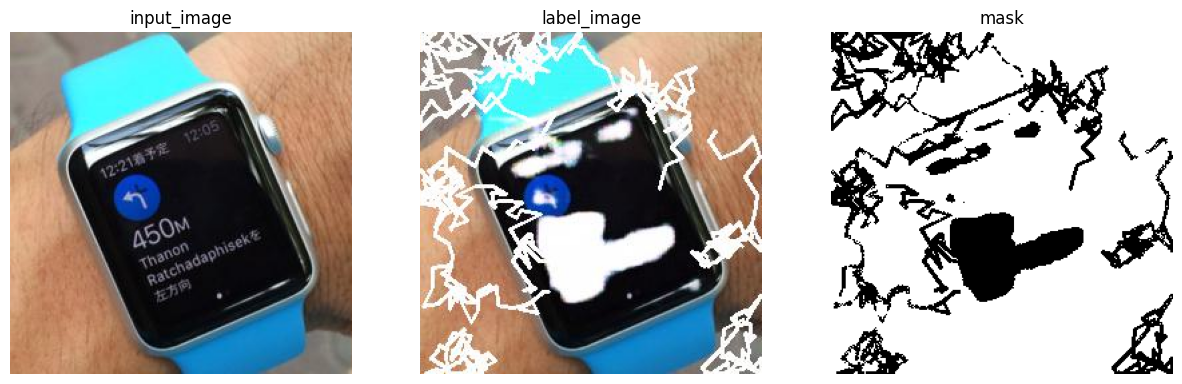

In [5]:

import matplotlib.pyplot as plt
import torch
import torchvision.transforms as T
from PIL import Image

def invert_white_black(input_image,label_image,mask):

    # Convert tensors back to PIL format
    transform_to_pil = T.ToPILImage()
    input_image = transform_to_pil(input_image[1])
    label_image = transform_to_pil(label_image[1])
    mask = transform_to_pil(mask[1])

    # Plot the original, inverted, and predicted images side by side
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))

    axs[0].imshow(input_image)
    axs[0].axis('off')  # Hide axes
    axs[0].set_title("input_image")

    axs[1].imshow(label_image)
    axs[1].axis('off')  # Hide axes
    axs[1].set_title("label_image")

    axs[2].imshow(mask)
    axs[2].axis('off')  # Hide axes
    axs[2].set_title("mask")

    plt.show()
    
# Example usage
# Assuming fixed_target is a tensor containing image data and modal is your trained model
# fixed_target = torch.randn(3, 256, 256)  # Dummy example, replace with actual image tensor
# modal = YourTrainedModel()  # Replace with the actual model instance
invert_white_black(input_image,label_image,mask)

In [6]:
# import matplotlib.pyplot as plt
# import torch
# import torchvision.transforms as T
# from PIL import Image

# def invert_white_black(image_tensor, model):
#     # Invert the colors
#     is_white = torch.all(image_tensor >= 0.9, dim=0)
#     inverted_tensor = image_tensor.clone()  # Clone the original tensor
#     inverted_tensor[:, is_white] = 0.0  # Set white pixels to black
#     inverted_tensor[:, ~is_white] = 1.0  # Set other pixels to white
    
#     model.eval()  # Set the generator to evaluation mode
    
#     with torch.no_grad():
#         prediction, _ = model(image_tensor.unsqueeze(0), inverted_tensor.unsqueeze(0))  # Unsqueeze to add batch dimension
#         prediction = prediction.squeeze(0)  # Remove the batch dimension after prediction

#     # Convert tensors back to PIL format
#     transform_to_pil = T.ToPILImage()
#     original_image = transform_to_pil(image_tensor)
#     inverted_image = transform_to_pil(inverted_tensor)
#     predicted_image = transform_to_pil(prediction)

#     # Plot the original, inverted, and predicted images side by side
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))

#     axs[0].imshow(original_image)
#     axs[0].axis('off')  # Hide axes
#     axs[0].set_title("Original Image")

#     axs[1].imshow(inverted_image)
#     axs[1].axis('off')  # Hide axes
#     axs[1].set_title("Inverted Image")

#     axs[2].imshow(predicted_image)
#     axs[2].axis('off')  # Hide axes
#     axs[2].set_title("Predicted Image")

#     plt.show()
    
# # Example usage
# # Assuming fixed_target is a tensor containing image data and modal is your trained model
# # fixed_target = torch.randn(3, 256, 256)  # Dummy example, replace with actual image tensor
# # modal = YourTrainedModel()  # Replace with the actual model instance
# invert_white_black(fixed_target[2], model)

In [7]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import transforms
import matplotlib.pyplot as plt
from torch.utils.tensorboard import SummaryWriter
import datetime
import os


In [8]:
import math

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models


def weights_init(init_type='gaussian'):
    def init_fun(m):
        classname = m.__class__.__name__
        if (classname.find('Conv') == 0 or classname.find(
                'Linear') == 0) and hasattr(m, 'weight'):
            if init_type == 'gaussian':
                nn.init.normal_(m.weight, 0.0, 0.02)
            elif init_type == 'xavier':
                nn.init.xavier_normal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'kaiming':
                nn.init.kaiming_normal_(m.weight, a=0, mode='fan_in')
            elif init_type == 'orthogonal':
                nn.init.orthogonal_(m.weight, gain=math.sqrt(2))
            elif init_type == 'default':
                pass
            else:
                assert 0, "Unsupported initialization: {}".format(init_type)
            if hasattr(m, 'bias') and m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

    return init_fun


class VGG16FeatureExtractor(nn.Module):
    def __init__(self):
        super().__init__()
        vgg16 = models.vgg16(pretrained=True)
        self.enc_1 = nn.Sequential(*vgg16.features[:5])
        self.enc_2 = nn.Sequential(*vgg16.features[5:10])
        self.enc_3 = nn.Sequential(*vgg16.features[10:17])

        # fix the encoder
        for i in range(3):
            for param in getattr(self, 'enc_{:d}'.format(i + 1)).parameters():
                param.requires_grad = False

    def forward(self, image):
        results = [image]
        for i in range(3):
            func = getattr(self, 'enc_{:d}'.format(i + 1))
            results.append(func(results[-1]))
        return results[1:]


class PartialConv(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1,
                 padding=0, dilation=1, groups=1, bias=True):
        super().__init__()
        self.input_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                    stride, padding, dilation, groups, bias)
        self.mask_conv = nn.Conv2d(in_channels, out_channels, kernel_size,
                                   stride, padding, dilation, groups, False)
        self.input_conv.apply(weights_init('kaiming'))

        torch.nn.init.constant_(self.mask_conv.weight, 1.0)

        # mask is not updated
        for param in self.mask_conv.parameters():
            param.requires_grad = False

    def forward(self, input, mask):
        # http://masc.cs.gmu.edu/wiki/partialconv
        # C(X) = W^T * X + b, C(0) = b, D(M) = 1 * M + 0 = sum(M)
        # W^T* (M .* X) / sum(M) + b = [C(M .* X) – C(0)] / D(M) + C(0)

        output = self.input_conv(input * mask)
        if self.input_conv.bias is not None:
            output_bias = self.input_conv.bias.view(1, -1, 1, 1).expand_as(
                output)
        else:
            output_bias = torch.zeros_like(output)

        with torch.no_grad():
            output_mask = self.mask_conv(mask)

        no_update_holes = output_mask == 0
        mask_sum = output_mask.masked_fill_(no_update_holes, 1.0)

        output_pre = (output - output_bias) / mask_sum + output_bias
        output = output_pre.masked_fill_(no_update_holes, 0.0)

        new_mask = torch.ones_like(output)
        new_mask = new_mask.masked_fill_(no_update_holes, 0.0)

        return output, new_mask


class PCBActiv(nn.Module):
    def __init__(self, in_ch, out_ch, bn=True, sample='none-3', activ='relu',
                 conv_bias=False):
        super().__init__()
        if sample == 'down-5':
            self.conv = PartialConv(in_ch, out_ch, 5, 2, 2, bias=conv_bias)
        elif sample == 'down-7':
            self.conv = PartialConv(in_ch, out_ch, 7, 2, 3, bias=conv_bias)
        elif sample == 'down-3':
            self.conv = PartialConv(in_ch, out_ch, 3, 2, 1, bias=conv_bias)
        else:
            self.conv = PartialConv(in_ch, out_ch, 3, 1, 1, bias=conv_bias)

        if bn:
            self.bn = nn.BatchNorm2d(out_ch)
        if activ == 'relu':
            self.activation = nn.ReLU()
        elif activ == 'leaky':
            self.activation = nn.LeakyReLU(negative_slope=0.2)

    def forward(self, input, input_mask):
        h, h_mask = self.conv(input, input_mask)
        if hasattr(self, 'bn'):
            h = self.bn(h)
        if hasattr(self, 'activation'):
            h = self.activation(h)
        return h, h_mask


class PConvUNet(nn.Module):
    def __init__(self, layer_size=7, input_channels=3, upsampling_mode='nearest'):
        super().__init__()
        self.freeze_enc_bn = False
        self.upsampling_mode = upsampling_mode
        self.layer_size = layer_size
        self.enc_1 = PCBActiv(input_channels, 64, bn=False, sample='down-7')
        self.enc_2 = PCBActiv(64, 128, sample='down-5')
        self.enc_3 = PCBActiv(128, 256, sample='down-5')
        self.enc_4 = PCBActiv(256, 512, sample='down-3')
        for i in range(4, self.layer_size):
            name = 'enc_{:d}'.format(i + 1)
            setattr(self, name, PCBActiv(512, 512, sample='down-3'))

        for i in range(4, self.layer_size):
            name = 'dec_{:d}'.format(i + 1)
            setattr(self, name, PCBActiv(512 + 512, 512, activ='leaky'))
        self.dec_4 = PCBActiv(512 + 256, 256, activ='leaky')
        self.dec_3 = PCBActiv(256 + 128, 128, activ='leaky')
        self.dec_2 = PCBActiv(128 + 64, 64, activ='leaky')
        self.dec_1 = PCBActiv(64 + input_channels, input_channels,
                              bn=False, activ=None, conv_bias=True)

    def forward(self, input, input_mask):
        h_dict = {}  # for the output of enc_N
        h_mask_dict = {}  # for the output of enc_N

        h_dict['h_0'], h_mask_dict['h_0'] = input, input_mask

        h_key_prev = 'h_0'
        for i in range(1, self.layer_size + 1):
            l_key = 'enc_{:d}'.format(i)
            h_key = 'h_{:d}'.format(i)
            h_dict[h_key], h_mask_dict[h_key] = getattr(self, l_key)(
                h_dict[h_key_prev], h_mask_dict[h_key_prev])
            h_key_prev = h_key

        h_key = 'h_{:d}'.format(self.layer_size)
        h, h_mask = h_dict[h_key], h_mask_dict[h_key]

        # concat upsampled output of h_enc_N-1 and dec_N+1, then do dec_N
        # (exception)
        #                            input         dec_2            dec_1
        #                            h_enc_7       h_enc_8          dec_8

        for i in range(self.layer_size, 0, -1):
            enc_h_key = 'h_{:d}'.format(i - 1)
            dec_l_key = 'dec_{:d}'.format(i)

            h = F.interpolate(h, scale_factor=2, mode=self.upsampling_mode)
            h_mask = F.interpolate(
                h_mask, scale_factor=2, mode='nearest')

            h = torch.cat([h, h_dict[enc_h_key]], dim=1)
            h_mask = torch.cat([h_mask, h_mask_dict[enc_h_key]], dim=1)
            h, h_mask = getattr(self, dec_l_key)(h, h_mask)

        return h, h_mask

    def train(self, mode=True):
        """
        Override the default train() to freeze the BN parameters
        """
        super().train(mode)
        if self.freeze_enc_bn:
            for name, module in self.named_modules():
                if isinstance(module, nn.BatchNorm2d) and 'enc' in name:
                    module.eval()


# if __name__ == '__main__':
#     size = (1, 3, 5, 5)
#     input = torch.ones(size)
#     input_mask = torch.ones(size)
#     input_mask[:, :, 2:, :][:, :, :, 2:] = 0

#     conv = PartialConv(3, 3, 3, 1, 1)
#     l1 = nn.L1Loss()
#     input.requires_grad = True

#     output, output_mask = conv(input, input_mask)
#     loss = l1(output, torch.randn(1, 3, 5, 5))
#     loss.backward()

#     assert (torch.sum(input.grad != input.grad).item() == 0)
#     assert (torch.sum(torch.isnan(conv.input_conv.weight.grad)).item() == 0)
#     assert (torch.sum(torch.isnan(conv.input_conv.bias.grad)).item() == 0)

#     # model = PConvUNet()
#     # output, output_mask = model(input, input_mask)


In [9]:
model = PConvUNet().to(device)

In [10]:
import torch
import torch.nn as nn


def gram_matrix(feat):
    (b, ch, h, w) = feat.size()
    feat = feat.view(b, ch, h * w)
    feat_t = feat.transpose(1, 2)
    gram = torch.bmm(feat, feat_t) / (ch * h * w)
    return gram

def total_variation_loss(image):
    loss = torch.mean(torch.abs(image[:, :, :, :-1] - image[:, :, :, 1:])) + \
        torch.mean(torch.abs(image[:, :, :-1, :] - image[:, :, 1:, :]))
    return loss

class InpaintingLoss(nn.Module):
    def __init__(self, extractor):
        super().__init__()
        self.l1 = nn.L1Loss()
        self.extractor = extractor
    def forward(self, input, mask, output, gt):
        loss_dict = {}
        output_comp = mask * input + (1 - mask) * output
        loss_dict['hole'] = self.l1((1 - mask) * output, (1 - mask) * gt)
        loss_dict['valid'] = self.l1(mask * output, mask * gt)
        if output.shape[1] == 3:
            feat_output_comp = self.extractor(output_comp)
            feat_output = self.extractor(output)
            feat_gt = self.extractor(gt)
        elif output.shape[1] == 1:
            feat_output_comp = self.extractor(torch.cat([output_comp]*3, 1))
            feat_output = self.extractor(torch.cat([output]*3, 1))
            feat_gt = self.extractor(torch.cat([gt]*3, 1))
        else:
            raise ValueError('Unsupported output shape')
        loss_dict['prc'] = 0.0
        for i in range(3):
            loss_dict['prc'] += self.l1(feat_output[i], feat_gt[i])
            loss_dict['prc'] += self.l1(feat_output_comp[i], feat_gt[i])
        loss_dict['style'] = 0.0
        for i in range(3):
            loss_dict['style'] += self.l1(gram_matrix(feat_output[i]),
                                          gram_matrix(feat_gt[i]))
            loss_dict['style'] += self.l1(gram_matrix(feat_output_comp[i]),
                                          gram_matrix(feat_gt[i]))
        loss_dict['tv'] = total_variation_loss(output_comp)
        return loss_dict


In [11]:


# ckpt_dict = torch.load("/kaggle/input/partial-conv-checkpoint-ex/iter_1000000.pth")
# #model.load_state_dict(ckpt_dict['model'], strict=False)
# model.load_state_dict(torch.load('/kaggle/input/checkpoint-for-partial-conv/checkpoint_epoch_50.pth'))
# optimizer = torch.optim.Adam(
#     filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)
# criterion = InpaintingLoss(VGG16FeatureExtractor()).to(device)
# optimizer.load_state_dict(ckpt_dict['optimizer'])
# #load_ckpt("/kaggle/input/partial-conv-checkpoint-ex/iter_1000000.pth",[('model', model)])

In [12]:
import torch


optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model.parameters()), lr=0.00001)

def load_checkpoint(filename):
    checkpoint = torch.load(filename)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epoch = checkpoint['epoch']
    return epoch

# Load the checkpoint
checkpoint_filename = '/kaggle/input/checkpointpatialconvwithcgan/checkpointWithWhiteLines_CGAN_epoch_40.pth'  # Replace X with the actual epoch number
start_epoch = load_checkpoint(checkpoint_filename)

# Now the model and optimizer have the state loaded from the checkpoint
print(f'Checkpoint loaded, starting from epoch {start_epoch}')


Checkpoint loaded, starting from epoch 40


In [13]:
# checkpoint = torch.load(checkpoint_filename)
# print(checkpoint.keys())


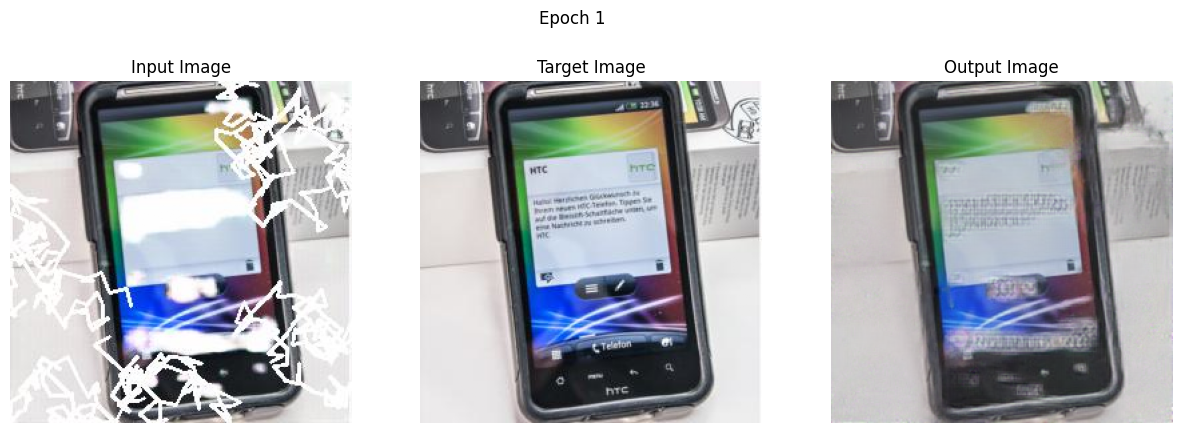

In [30]:
import numpy as np
import matplotlib.pyplot as plt

def plot_images(inputs, targets, outputs, epoch):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    def normalize_and_plot(ax, img, title):
        img = img.permute(1, 2, 0).cpu().numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalization to [0, 1]
        ax.imshow(img)
        ax.axis('off')
        ax.set_title(title)

    normalize_and_plot(axs[0], inputs[0], 'Input Image')
    normalize_and_plot(axs[1], targets[0], 'Target Image')
    normalize_and_plot(axs[2], outputs[0], 'Output Image')
    
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

model.eval()
with torch.no_grad():
    #whole input mask
    test_inputs, test_label, test_masks = next(iter(test_loader))
    test_inputs, test_masks, test_label = test_inputs.to(device), test_masks.to(device), test_label.to(device)
    test_outputs, _ = model(test_label, test_masks)
    plot_images(test_label, test_inputs, test_outputs,  1)
model.train()

In [28]:
import matplotlib.pyplot as plt
import torch

def save_checkpoint(model, optimizer, epoch, filename='checkpoint.pth.tar'):
    state = {
        'epoch': epoch,
        'model_state': model.state_dict(),
        'optimizer_state': optimizer.state_dict()
    }
    torch.save(state, filename)

def plot_images(inputs, targets, outputs, epoch):
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    
    axs[0].imshow(inputs[0].permute(1, 2, 0).cpu())
    axs[0].axis('off')
    axs[0].set_title('Input Image')
    
    axs[1].imshow(targets[0].permute(1, 2, 0).cpu())
    axs[1].axis('off')
    axs[1].set_title('Target Image')
    
    axs[2].imshow(outputs[0].permute(1, 2, 0).cpu())
    axs[2].axis('off')
    axs[2].set_title('Output Image')
    
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

def train_model(model, criterion, optimizer, dataloader, num_epochs=25, device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'), checkpoint_interval=10, plot_interval=10):
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        
        for inputs,labels,masks in dataloader:
            inputs, masks, labels = inputs.to(device), masks.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs, _ = model(labels, masks)
            loss_dict = criterion(labels,masks,outputs,inputs)
            loss = sum(loss_dict.values())
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)
        epoch_loss = running_loss / len(dataloader.dataset)
        print(f'Epoch {epoch}/{num_epochs - 1} Loss: {epoch_loss:.4f}')

        if (epoch + 1) % plot_interval == 0:
            model.eval()
            with torch.no_grad():
                #whole input mask
                test_inputs, test_label, test_masks = next(iter(dataloader))
                test_inputs, test_masks, test_label = test_inputs.to(device), test_masks.to(device), test_label.to(device)
                test_outputs, _ = model(test_label, test_masks)
                plot_images(test_label, test_inputs, test_outputs, epoch + 1)
            model.train()

        if (epoch + 1) % checkpoint_interval == 0:
            checkpoint_filename = f'checkpointWithWhiteLines_CGAN_epoch_{epoch + 1}.pth'
            save_checkpoint(model, optimizer, epoch + 1, filename=checkpoint_filename)

    return model


criterion = InpaintingLoss(VGG16FeatureExtractor()).to(device)

trained_model = train_model(model, criterion, optimizer, test_loader, num_epochs=40)


KeyboardInterrupt: 

In [ ]:
# class Downsample(nn.Module):
#     def __init__(self, in_channels, out_channels, apply_batchnorm=True):
#         super(Downsample, self).__init__()
#         self.conv = nn.Conv2d(in_channels, out_channels, 4, stride=2, padding=1, bias=not apply_batchnorm)
#         self.batchnorm = nn.BatchNorm2d(out_channels) if apply_batchnorm else nn.Identity()
#         self.activation = nn.LeakyReLU(0.2)

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.batchnorm(x)
#         return self.activation(x)

# class Upsample(nn.Module):
#     def __init__(self, in_channels, out_channels, apply_dropout=False):
#         super(Upsample, self).__init__()
#         self.conv = nn.ConvTranspose2d(in_channels, out_channels, 4, stride=2, padding=1, bias=False)
#         self.batchnorm = nn.BatchNorm2d(out_channels)
#         self.dropout = nn.Dropout(0.5) if apply_dropout else nn.Identity()
#         self.activation = nn.ReLU()

#     def forward(self, x):
#         x = self.conv(x)
#         x = self.batchnorm(x)
#         x = self.dropout(x)
#         return self.activation(x)


In [ ]:
# class Generator(nn.Module):
#     def __init__(self):
#         super(Generator, self).__init__()
#         self.down_blocks = nn.ModuleList([
#             Downsample(3, 64, apply_batchnorm=False),
#             Downsample(64, 128),
#             Downsample(128, 256),
#             Downsample(256, 512),
#             Downsample(512, 512),
#             Downsample(512, 512),
#             Downsample(512, 512),
#             Downsample(512, 512)
#         ])
#         self.up_blocks = nn.ModuleList([
#             Upsample(512, 512, apply_dropout=True),
#             Upsample(1024, 512, apply_dropout=True),
#             Upsample(1024, 512, apply_dropout=True),
#             Upsample(1024, 512),
#             Upsample(1024, 256),
#             Upsample(512, 128),
#             Upsample(256, 64)
#         ])
#         self.final = nn.Sequential(
#             nn.ConvTranspose2d(128, 3, 4, 2, 1),
#             nn.Tanh()
#         )

#     def forward(self, x):
#         connections = []
#         for down in self.down_blocks:
#             x = down(x)
#             connections.append(x)
#         connections = connections[:-1][::-1]
#         for up, conn in zip(self.up_blocks, connections):
#             x = up(x)
#             x = torch.cat([x, conn], 1)
#         return self.final(x)


In [ ]:
# class Discriminator(nn.Module):
#     def __init__(self):
#         super(Discriminator, self).__init__()
#         self.initial = Downsample(6, 64, apply_batchnorm=False)
#         self.down_blocks = nn.Sequential(
#             Downsample(64, 128),
#             Downsample(128, 256),
#             Downsample(256, 512),
#         )
#         self.zero_pad = nn.ZeroPad2d(1)
#         self.final = nn.Conv2d(512, 1, kernel_size=4, stride=1, padding=1)

#     def forward(self, inp, tar):
#         x = torch.cat([inp, tar], dim=1)
#         x = self.initial(x)
#         x = self.down_blocks(x)
#         x = self.zero_pad(x)
#         return self.final(x)


In [ ]:
# import torch

# # Assuming generator and discriminator are instances of nn.Module
# generator = Generator().to(device)
# discriminator = Discriminator().to(device)


In [ ]:
# generator.load_state_dict(torch.load('/kaggle/input/checkpoint/generator_epoch_300.pth'))
# discriminator.load_state_dict(torch.load('/kaggle/input/checkpoint/discriminator_epoch_300.pth'))

In [ ]:
# generator.load_state_dict(torch.load('/kaggle/input/checkpointforcganwithwhite/generator_with_white_epoch_100.pth'))
# discriminator.load_state_dict(torch.load('/kaggle/input/checkpoint-for-image015/discriminator_epoch_100.pth'))

In [ ]:
# fixed_input, fixed_target = next(iter(data_loader))
# fixed_input, fixed_target = fixed_input.to(device), fixed_target.to(device)

In [ ]:
# generate_images(generator, fixed_input, fixed_target,1, display=True)


In [ ]:
# import matplotlib.pyplot as plt

# def generate_images(generator, test_input, target, epoch, display=True):
#     generator.eval()  # Set the generator to evaluation mode
    
#     is_white = torch.all(test_input >= 0.8, dim=0)
#     inverted_tensor = test_input.clone()  # Clone the original tensor
#     inverted_tensor[:, is_white] = 0.0  # Set white pixels to black
#     inverted_tensor[:, ~is_white] = 1.0  # Set other pixels to white
    
#     with torch.no_grad():
#         prediction, _ = generator(test_input, inverted_tensor)
    
#     # Move data to CPU
#     test_input = test_input.cpu()
#     target = target.cpu()
#     prediction = prediction.cpu()
#     inverted_tensor = inverted_tensor.cpu()
    
#     # Each image type will have its own column, and images will be displayed in rows
#     fig, axs = plt.subplots(10, 4, figsize=(10, 40))  # 10 rows, 3 columns
    
#     for i in range(10):  # Assuming there are exactly 10 images in the batch
#         axs[i, 0].imshow(test_input[i].permute(1, 2, 0) )
#         axs[i, 0].set_title('Input Image')
#         axs[i, 0].axis('off')
    
#         axs[i, 1].imshow(target[i].permute(1, 2, 0) )
#         axs[i, 1].set_title('Real Image')
#         axs[i, 1].axis('off')
    
#         axs[i, 2].imshow(prediction[i].permute(1, 2, 0) * 0.5 + 0.5)
#         axs[i, 2].set_title('Generated Image')
#         axs[i, 2].axis('off')
        
#         axs[i, 3].imshow(inverted_tensor[i].permute(1, 2, 0))
#         axs[i, 3].set_title('inverted_tensor')
#         axs[i, 3].axis('off')
    
#     plt.suptitle(f'Epoch {epoch}')
#     if display:
#         plt.show()
#     plt.close()
    
#     generator.train()  # Set the generator back to training mode


In [ ]:
# generate_images(model,fixed_target,fixed_input,1, display=True)

In [ ]:
# def generator_loss(disc_generated_output, gen_output, target, l1_lambda=100):
#     # Ensure all tensors are on the same device
#     disc_generated_output = disc_generated_output.to(device)
#     gen_output = gen_output.to(device)
#     target = target.to(device)
    
#     # Calculate losses
#     bce_loss = F.binary_cross_entropy_with_logits(disc_generated_output, torch.ones_like(disc_generated_output))
#     l1_loss = F.l1_loss(gen_output, target)
#     total_gen_loss = bce_loss + l1_lambda * l1_loss
#     return total_gen_loss

# def discriminator_loss(disc_output, labels):
#     disc_output = disc_output.to(device)
#     labels = labels.to(device)
#     return F.binary_cross_entropy_with_logits(disc_output, labels)



In [ ]:
# def generate_images(model, test_input, tar):
#     model.eval()
#     with torch.no_grad():
#         prediction = model(test_input)
#     fig, axs = plt.subplots(1, 3, figsize=(15, 5))
#     axs[0].imshow(test_input[0].permute(1, 2, 0).cpu() * 0.5 + 0.5)
#     axs[0].set_title('Input Image')
#     axs[1].imshow(tar[0].permute(1, 2, 0).cpu() * 0.5 + 0.5)
#     axs[1].set_title('Ground Truth')
#     axs[2].imshow(prediction[0].permute(1, 2, 0).cpu() * 0.5 + 0.5)
#     axs[2].set_title('Predicted Image')
#     for ax in axs:
#         ax.axis('off')
#     plt.show()


In [ ]:
# def generate_images(generator, test_input, target, epoch, display=True):
#     generator.eval()  # Set the generator to evaluation mode
#     with torch.no_grad():
#         prediction = generator(test_input).to('cpu')

#     test_input = test_input.to('cpu')
#     target = target.to('cpu')
    
#     # Each image type will have its own column, and images will be displayed in rows
#     fig, axs = plt.subplots(10, 3, figsize=(15, 40))  # 10 rows, 3 columns

#     for i in range(10):  # Assuming there are exactly 10 images in the batch
#         axs[i, 0].imshow(test_input[i].permute(1, 2, 0) * 0.5 + 0.5)
#         axs[i, 0].set_title('Input Image')
#         axs[i, 0].axis('off')

#         axs[i, 1].imshow(target[i].permute(1, 2, 0) * 0.5 + 0.5)
#         axs[i, 1].set_title('Real Image')
#         axs[i, 1].axis('off')

#         axs[i, 2].imshow(prediction[i].permute(1, 2, 0) * 0.5 + 0.5)
#         axs[i, 2].set_title('Generated Image')
#         axs[i, 2].axis('off')

#     plt.suptitle(f'Epoch {epoch}')
#     if display:
#         plt.show()
#     plt.close()

#     generator.train()  # Set the generator back to training mode


In [ ]:
# def train_step(generator, discriminator, input_image, target, g_optim, d_optim, l1_lambda=100):
#     input_image = input_image.to(device)
#     target = target.to(device)
    
#     # Clear gradients
#     g_optim.zero_grad()
#     d_optim.zero_grad()

#     # Generator forward pass
#     fake_target = generator(input_image)
    
#     # Calculate generator loss
#     disc_generated_output = discriminator(input_image, fake_target.detach())  # Ensure detachment
#     gen_loss = generator_loss(disc_generated_output, fake_target, target, l1_lambda)
#     gen_loss.backward()
#     g_optim.step()

    
    
#     # Discriminator forward pass and loss calculations
#     disc_real_output = discriminator(input_image, target)
#     real_loss = discriminator_loss(disc_real_output, torch.ones_like(disc_real_output).to(device))
    
#     disc_generated_output = discriminator(input_image, fake_target.detach())  # Detach again to ensure no gradients
#     fake_loss = discriminator_loss(disc_generated_output, torch.zeros_like(disc_generated_output).to(device))
#     disc_loss = (real_loss + fake_loss) / 2
#     disc_loss.backward()
#     d_optim.step()

#     return gen_loss.item(), disc_loss.item()


In [ ]:
# def fit(train_loader, generator, discriminator, g_optim, d_optim, epochs, device):
#     # Fetch one batch of data to use for periodic visualization (from test_loader or train_loader)
#     fixed_input, fixed_target = next(iter(train_loader))
#     fixed_input, fixed_target = fixed_input.to(device), fixed_target.to(device)

#     for epoch in range(epochs):
#         for i, (input_image, target) in enumerate(train_loader):
#             input_image, target = input_image.to(device), target.to(device)
#             gen_loss, disc_loss = train_step(generator, discriminator, input_image, target, g_optim, d_optim)
            
#             if i % 400 == 0:
#                 print(f'Epoch [{epoch + 1}/{epochs}], Step [{i + 1}/{len(train_loader)}], Gen Loss: {gen_loss}, Disc Loss: {disc_loss}')

# #         # Generate images from the fixed batch every 5 epochs
# #         if (epoch + 1) % 1 == 0:
# #             print(f"Displaying generated images at Epoch: {epoch + 1}")
# #             generate_images(generator, fixed_input, fixed_target, epoch + 1, display=True)

#         # Optional: Save model checkpoints
#         if (epoch + 1) % 25 == 0:
#             torch.save(generator.state_dict(), f'generator_with_white_epoch_{epoch+1}.pth')
#             torch.save(discriminator.state_dict(), f'discriminator_with_white_epoch_{epoch+1}.pth')

#         print(f'Epoch {epoch + 1} completed.')


In [ ]:
# # Optimizers
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))


In [ ]:
#fit(data_loader, generator, discriminator, g_optimizer, d_optimizer, 300, device)


In [ ]:
# # Optimizers
# g_optimizer = optim.Adam(generator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# d_optimizer = optim.Adam(discriminator.parameters(), lr=0.0001, betas=(0.5, 0.999))
# fit(data_loader, generator, discriminator, g_optimizer, d_optimizer, 100, device)
